In [1]:
# import keras
# from keras.datasets import cifar10
# from keras.models import Model, Sequential
# from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
# from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from keras.layers import Concatenate
# from keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam

In [0]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf

In [0]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 10
l = 40
num_filter = 12
compression = 0.5
dropout_rate = 0.2

In [4]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

170500096/170498071 [==============================] - 4s 0us/step


In [5]:
X_train.shape

(50000, 32, 32, 3)

In [6]:
X_test.shape

(10000, 32, 32, 3)

In [0]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

In [0]:

num_filter = 12
dropout_rate = 0.2
l = 12
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

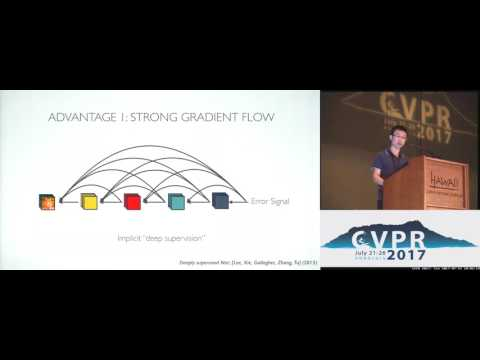

In [0]:
#https://arxiv.org/pdf/1608.06993.pdf
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo(id='-W6y8xnd--U', width=600)

In [0]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 12)   324         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 12)   48          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 12)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [0]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [0]:
model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1, 
                    validation_data=(X_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 66s 1ms/sample - loss: 1.5326 - acc: 0.4339 - val_loss: 1.7971 - val_acc: 0.3777
Epoch 2/10
50000/50000 [==============================] - 63s 1ms/sample - loss: 1.3113 - acc: 0.5198 - val_loss: 1.5268 - val_acc: 0.4811
Epoch 3/10
50000/50000 [==============================] - 63s 1ms/sample - loss: 1.1942 - acc: 0.5669 - val_loss: 1.2360 - val_acc: 0.5562
Epoch 4/10
50000/50000 [==============================] - 63s 1ms/sample - loss: 1.1025 - acc: 0.6053 - val_loss: 1.1624 - val_acc: 0.5958
Epoch 5/10
50000/50000 [==============================] - 63s 1ms/sample - loss: 1.0459 - acc: 0.6238 - val_loss: 1.2096 - val_acc: 0.5858
Epoch 6/10
50000/50000 [==============================] - 63s 1ms/sample - loss: 0.9942 - acc: 0.6443 - val_loss: 1.1280 - val_acc: 0.6099
Epoch 7/10
50000/50000 [==============================] - 62s 1ms/sample - loss: 0.9592 - acc: 0.6570 - val_loss: 1.

In [0]:
# Test the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [0]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model.h5")
print("Saved model to disk")

Saved model to disk


<h3>CNN on CIFR Assignment:

In [0]:
X_train[1:2,1:2,1:2]

array([[[[145, 153, 154]]]], dtype=uint8)

Dataset is not normalized ,need to normalize the data set. 

In [0]:
print(X_train.max(),X_train.min())

255 0


In [0]:
#X => (X - Xmin)/(Xmax-Xmin) = X/255
X_train=X_train/255
X_test=X_test/255
X_train[1:2,1:2,1:2]

array([[[[0.56862745, 0.6       , 0.60392157]]]])

2 .created a copy of DenseNet<br>

3 .Removed Dense Layers abd DropOut layers.

In [0]:
# Dense Block
#Remove dropout layer by setting dropout_rate = 0
def denseblock_1(input, num_filter = 12, dropout_rate = 0):
  global compression
  temp = input
  for _ in range(l):
    BatchNorm = layers.BatchNormalization()(temp)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
      Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
    concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
    temp = concat
        
  return temp

## transition Blosck
#Remove dropout layer by setting dropout_rate = 0
def transition_1(input, num_filter = 12, dropout_rate = 0):
  global compression
  BatchNorm = layers.BatchNormalization()(input)
  relu = layers.Activation('relu')(BatchNorm)
  Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
  if dropout_rate>0:
    Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
  avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
  return avg

#output layer
def output_layer_1(input):
  global compression
  BatchNorm = layers.BatchNormalization()(input)
  relu = layers.Activation('relu')(BatchNorm)
  AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
  conv=layers.Conv2D(num_classes, kernel_size = (2,2))(AvgPooling)
  output = Activation('softmax')(conv)

  #output = layers.Dense(num_classes, activation='softmax')(flat)
  # got error as mentioned "A target array with shape (50000, 10) was passed for an output of shape (None, 1, 1, 10)" so added flatten layer at the end
  output = Flatten()(output)
  return output

In [0]:
tf.keras.backend.clear_session()
num_filter = 36
dropout_rate = 0
l = 12
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock_1(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition_1(First_Block, num_filter, dropout_rate)

Second_Block = denseblock_1(First_Transition, num_filter, dropout_rate)
Second_Transition = transition_1(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock_1(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition_1(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock_1(Third_Transition,  num_filter, dropout_rate)
output = output_layer_1(Last_Block)

In [0]:
model_2 = Model(inputs=[input], outputs=[output])
model_2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 36)   972         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 36)   144         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 36)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [0]:
# determine Loss function and Optimizer
model_2.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

4. Without use Image Augmentation Techniques

In [0]:
model_2.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=300,
                    verbose=1, 
                    validation_data=(X_test, y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 50000 samples, validate on 10000 samples
Epoch 1/300
50000/50000 [==============================] - 134s 3ms/sample - loss: 1.3443 - acc: 0.5108 - val_loss: 1.7591 - val_acc: 0.3901
Epoch 2/300
50000/50000 [==============================] - 115s 2ms/sample - loss: 0.8689 - acc: 0.6896 - val_loss: 1.0018 - val_acc: 0.6554
Epoch 3/300
50000/50000 [==============================] - 115s 2ms/sample - loss: 0.6847 - acc: 0.7581 - val_loss: 0.7081 - val_acc: 0.7513
Epoch 4/300
50000/50000 [==============================] - 115s 2ms/sample - loss: 0.5676 - acc: 0.8010 - val_loss: 1.1526 - val_acc: 0.6628
Epoch 5/300
50000/50000 [==============================] - 115s 2ms/sample - loss: 0.4913 - acc: 0.8289 - val_loss: 0.7590 - val_acc: 0.7545
Epoch 6/300
50000/50000 [==============================] - 115s 2ms/sample - loss: 0.4226 - acc: 0.8523 - val_loss: 0.9314 - val_acc: 0.7074
Epoch 7/30

4. Using Image Augmentation Techniques

In [0]:
from keras.preprocessing.image import ImageDataGenerator
# Data augementation
image_gen = ImageDataGenerator(rotation_range=20,width_shift_range=0.125,height_shift_range=0.125,horizontal_flip=True,fill_mode='nearest',zoom_range=0.10)

image_gen.fit(X_train)

Using TensorFlow backend.


In [0]:
X_train.shape

(50000, 32, 32, 3)

In [0]:
# determine Loss function and Optimizer

model_3 = Model(inputs=[input], outputs=[output])
model_3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 36)   972         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 36)   144         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 36)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [0]:
model_3.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model_3.fit_generator(image_gen.flow(X_train, y_train, batch_size), steps_per_epoch = X_train.shape[0]/batch_size, epochs = 300, validation_data =(X_test,y_test),)


Epoch 1/300
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
391/390 [==============================] - 90s 229ms/step - loss: 1.5474 - acc: 0.4341 - val_loss: 1.6082 - val_acc: 0.4521
Epoch 2/300
391/390 [==============================] - 69s 176ms/step - loss: 1.1380 - acc: 0.5917 - val_loss: 1.8910 - val_acc: 0.4773
Epoch 3/300
391/390 [==============================] - 69s 177ms/step - loss: 0.9521 - acc: 0.6614 - val_loss: 1.5820 - val_acc: 0.5218
Epoch 4/300
391/390 [==============================] - 69s 176ms/step - loss: 0.8325 - acc: 0.7060 - val_loss: 1.0040 - val_acc: 0.6709
Epoch 5/300
391/390 [==============================] - 69s 177ms/step - loss: 0.7499 - acc: 0.7358 - val_loss: 0.8748 - val_acc: 0.7050
Epoch 6/300
391/390 [==============================] - 69s 177ms/step - loss: 0.6912 - acc: 0.7608 - val_loss: 0.8572 - val_acc: 0.7196
Epoch 7/300
391/390 [==============================] - 69s 177ms/step - loss: 0.6497 - acc

In [0]:
model_3.evaluate(X_test,y_test)

10000/10000 [==============================] - 5s 540us/sample - loss: 0.4462 - acc: 0.9112


[0.4461723472420126, 0.9112]

 this model got 91.1% test accuracy